In [7]:
import numpy as np
from transforms3d.euler import mat2euler, quat2euler
from load_data import read_data
import matplotlib.pyplot as plt

In [8]:
# Load and process data
def process_data(dataset_num):
    ifile = f"data/imu/imuRaw{dataset_num}.p"
    vfile = f"data/vicon/viconRot{dataset_num}.p"

    imud = read_data(ifile)
    vicd = read_data(vfile)
    
    gyro_bias = [-511., -500., 605.14]
    accel_bias = [373.58, 375.425, 359.805]

    timestamps = imud[0]
    gyro_x = imud[1] - gyro_bias[0]
    gyro_y = imud[2] - gyro_bias[1]
    gyro_z = imud[3] - gyro_bias[2]
    accel_x = imud[4] - accel_bias[0]
    accel_y = imud[5] - accel_bias[1]
    accel_z = imud[6] - accel_bias[2]
    
    dt = np.diff(np.array(imud[0]))
    
    return gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z, dt, vicd

In [13]:
import numpy as np

def motion_model_batch(q_prev, tau_omega):
    """Vectorized motion model for batch processing"""
    v = tau_omega / 2.0
    delta_q = qexp_batch(v)
    return qmult_batch(q_prev, delta_q)

def qexp_batch(v):
    """Vectorized quaternion exponential"""
    theta = np.linalg.norm(v, axis=1)
    theta = np.where(theta < 1e-7, 1e-7, theta)
    
    normalized_v = v / theta[:, np.newaxis]
    q = np.zeros((v.shape[0], 4))
    q[:, 0] = np.cos(theta)
    q[:, 1:] = normalized_v * np.sin(theta)[:, np.newaxis]
    return q

def qmult_batch(q1, q2):
    """Vectorized quaternion multiplication"""
    w1, x1, y1, z1 = q1[:, 0], q1[:, 1], q1[:, 2], q1[:, 3]
    w2, x2, y2, z2 = q2[:, 0], q2[:, 1], q2[:, 2], q2[:, 3]
    
    return np.stack([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ], axis=1)

def qinverse_batch(q):
    """Vectorized quaternion inverse"""
    return np.stack([q[:, 0], -q[:, 1], -q[:, 2], -q[:, 3]], axis=1)

def observation_model_batch(q, g=9.81):
    """Vectorized observation model"""
    gravity_world = np.array([0.0, 0.0, -g])
    gravity_quat = np.array([0.0, *gravity_world])
    
    q_inv = qinverse_batch(q)
    temp = qmult_batch(q_inv, np.tile(gravity_quat, (q.shape[0], 1)))
    result = qmult_batch(temp, q)
    return result[:, 1:]

def cost_function_vectorized(q_traj, gyro_data, accel_data, dt):
    """Vectorized cost function computation"""
    # Ensure all data has the same length for the motion model
    T = len(q_traj) - 1
    
    # Motion error
    # Broadcast dt to match gyro_data shape
    tau_omega = (dt[:T, np.newaxis] * gyro_data[:T])
    q_pred = motion_model_batch(q_traj[:T], tau_omega)
    rel_q = qmult_batch(qinverse_batch(q_traj[1:]), q_pred)
    angles = 2.0 * np.arccos(np.clip(np.abs(rel_q[:, 0]), 0.0, 1.0))
    motion_error = np.sum(angles**2)
    
    # Observation error
    a_pred = observation_model_batch(q_traj)
    obs_error = np.sum((accel_data - a_pred)**2)
    
    return 0.5 * (motion_error + obs_error)

def compute_gradient_vectorized(q_traj, gyro_data, accel_data, dt):
    """Vectorized gradient computation"""
    eps = 1e-7
    grad = np.zeros_like(q_traj)
    T = len(q_traj)
    
    # Compute gradient for each quaternion component
    for i in range(T):
        for j in range(4):
            q_plus = q_traj.copy()
            q_minus = q_traj.copy()
            
            q_plus[i, j] += eps
            q_minus[i, j] -= eps
            
            cost_plus = cost_function_vectorized(q_plus, gyro_data, accel_data, dt)
            cost_minus = cost_function_vectorized(q_minus, gyro_data, accel_data, dt)
            
            grad[i, j] = (cost_plus - cost_minus) / (2 * eps)
    
    return grad

def optimize_orientation_vectorized(gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z, dt):
    """Optimized orientation estimation using vectorized operations"""
    lr = 0.01
    n_iterations = 1
    
    # Ensure all input arrays have the same length
    T = min(len(gyro_x), len(dt) + 1)
    
    # Prepare data in batched format and trim to consistent length
    gyro_data = np.stack([gyro_x[:T], gyro_y[:T], gyro_z[:T]], axis=1)
    accel_data = np.stack([accel_x[:T], accel_y[:T], accel_z[:T]], axis=1)
    dt = dt[:T-1]  # dt needs one fewer element than the trajectory
    
    # Initialize trajectory
    q_init = np.array([1.0, 0.0, 0.0, 0.0])
    q_traj = np.tile(q_init, (T, 1))
    
    # Optimization loop
    for i in range(n_iterations):
        if i % 100 == 0:
            print(f"Iteration {i}/{n_iterations}")
            current_cost = cost_function_vectorized(q_traj, gyro_data, accel_data, dt)
            print(f"Current cost: {current_cost}")
            
        grad = compute_gradient_vectorized(q_traj, gyro_data, accel_data, dt)
        print("c1")
        q_traj = q_traj - lr * grad
        q_traj = q_traj / np.linalg.norm(q_traj, axis=1)[:, np.newaxis]
    
    return q_traj

In [14]:
dataset = "2"
gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z, dt, vicd = process_data(dataset)
    
q_traj = optimize_orientation_vectorized(gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z, dt)
print("Shape of q_traj:", q_traj.shape)
print("First few quaternions:", q_traj[:5])

euler_estimated = np.array([quat2euler(q, axes='sxyz') for q in q_traj])

rots = vicd['rots']  # Extract rotation matrices

euler_vicon = np.array([mat2euler(rots[:, :, i], axes='sxyz') for i in range(rots.shape[2])])

print("euler_vicon shape:", euler_vicon.shape)
print("euler_estimated shape:", euler_estimated.shape)


Iteration 0/1
Current cost: 3190691.2976349946
c1
Shape of q_traj: (4698, 4)
First few quaternions: [[-9.98228851e-01 -4.18888079e-02 -4.22432117e-02  1.72879933e-05]
 [-9.98946381e-01 -3.70616539e-02  2.70658673e-02  0.00000000e+00]
 [-9.98584660e-01  3.14415806e-02 -4.28964277e-02  0.00000000e+00]
 [-9.98772801e-01  2.92787079e-02 -3.99455739e-02  0.00000000e+00]
 [-9.99021889e-01  3.14553472e-02  3.10777425e-02  0.00000000e+00]]
euler_vicon shape: (4601, 3)
euler_estimated shape: (4698, 3)


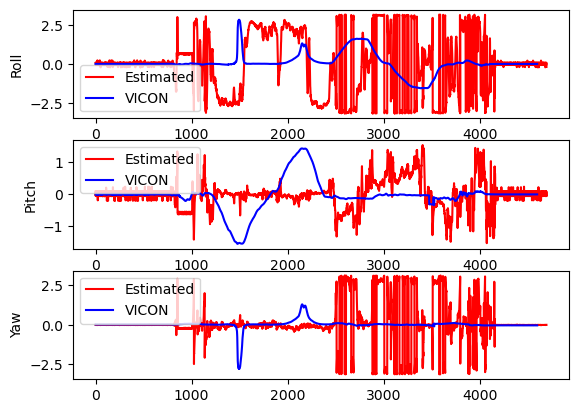

In [16]:
plt.figure()
for i, label in enumerate(['Roll', 'Pitch', 'Yaw']):
        plt.subplot(3, 1, i+1)
        plt.plot(euler_estimated[:, i], 'r', label='Estimated')
        plt.plot(euler_vicon[:, i], 'b', label='VICON')
        plt.ylabel(label)
        plt.legend()
plt.show()